In [133]:
import pandas as pd
import seaborn as sns
import matplotlib as plt
from matplotlib import dates
import os

In [149]:
dow = ['SUN', 'MON', 'TUE', 'WED', 'THU', 'FRI', 'SAT']
report_data = pd.DataFrame()
data_path = 'data/'
for file in os.listdir(data_path):
    
    # Check the working folder for csv files
    if file.endswith(".csv"):
        
        # Drop header info, footer info, Rename time column and drop padding
        main_df = pd.read_csv(data_path + file, skipfooter=3, header = 7, engine='python')
        main_df = main_df.rename(columns={"Unnamed: 0": 'Time'})
        main_df['Time'] = pd.to_datetime(main_df['Time'], format="%H:%M").dt.time
        main_df.drop(main_df.filter(regex='Unnamed').columns, axis = 1, inplace = True)
        
        # Iterate through columns to stack them by day of the week
        data = pd.DataFrame()
        for day in dow:

            df = main_df.iloc[:,0:4].copy()
            df.columns=['Time', 'Road', 'PDir', 'NDir']
            main_df = main_df.drop(main_df.columns[[1 ,2 ,3]], axis=1).copy()
            df['Weekday']= day
            data = pd.concat([data, df])
        
        data.replace(',', '', regex=True, inplace=True)
        data[['Road', 'PDir', 'NDir']] = data[['Road', 'PDir', 'NDir']].astype(int)
        # Add Bridge
        if "Lions Gate" in file:
            data['Bridge'] = "Lion's Gate"
        if 'Second Narrows' in file:
            data['Bridge'] = 'Second Narrows'
        
        # Add Date from filename
        data['Year'] = file[-8:-4]

        # Save cleaned data for each subset to csv
        if not os.path.exists('clean'):
            os.mkdir('clean')
        data.to_csv(f"clean/{file.replace('.csv', '')}_clean.csv")
        
        # Build working table
        report_data = pd.concat([report_data, data])

report_data
   

,Time,Road,PDir,NDir,Weekday,Bridge,Year
0,00:00:00,1139,679,459,SUN,Lion's Gate,2019
1,01:00:00,755,441,314,SUN,Lion's Gate,2019
2,02:00:00,505,284,220,SUN,Lion's Gate,2019
3,03:00:00,376,208,167,SUN,Lion's Gate,2019
4,04:00:00,267,128,138,SUN,Lion's Gate,2019
...,...,...,...,...,...,...,...
19,19:00:00,4615,2683,1932,SAT,Second Narrows,2021
20,20:00:00,3670,2124,1546,SAT,Second Narrows,2021
21,21:00:00,3163,1812,1351,SAT,Second Narrows,2021
22,22:00:00,2574,1470,1103,SAT,Second Narrows,2021


TypeError: float() argument must be a string or a real number, not 'datetime.time'

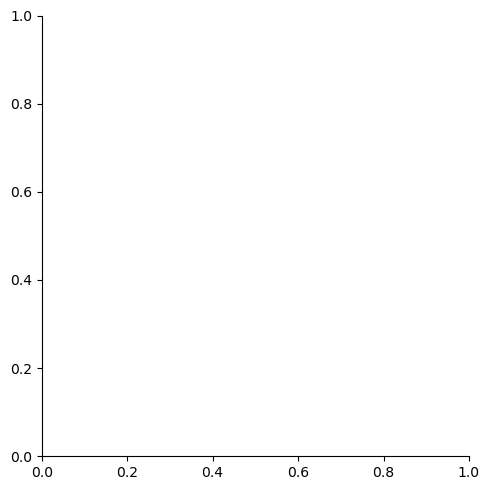

In [150]:
sns.lmplot(y='Time', x='Road', data=report_data, hue='Bridge')